In [19]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from torch_geometric.data import Data
import torch_geometric
import networkx as nx

from sklearn.model_selection import train_test_split

from ClusterDatasetTransformer import ClusterDataset
from training import *
from data_statistics import *

from IPython.display import display

from Transformer import Transformer
from lang import Lang
from LossFunction import Loss

In [20]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [21]:
input_length = 60
max_seq_length = 60
batch_size = 64
max_nodes = 66

In [22]:
converter = Lang(max_nodes)
vocab_size = converter.n_words

In [23]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo/"
data_folder_training = "/eos/user/c/czeh/graph_data/processed"
store_folder_training = "/eos/user/c/czeh/graph_data_trans"
data_folder_test = "/eos/user/c/czeh/graph_data_test/processed"
store_folder_test = "/eos/user/c/czeh/graph_data_trans_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(converter, store_folder_training, data_folder_training, max_nodes=max_nodes, input_length=input_length)
dataset_test = ClusterDataset(converter, store_folder_test, data_folder_test, max_nodes=max_nodes, input_length=input_length)

In [24]:
train_dl = DataLoader(dataset_training, shuffle=True, batch_size=batch_size)
test_dl = DataLoader(dataset_test, shuffle=True, batch_size=batch_size)

In [33]:
epochs = 100
d_model = 16
num_heads = 2
num_layers = 4
d_ff = 32
dropout = 0
padding = converter.word2index["<PAD>"]
feature_num = len(dataset_test.model_feature_keys)

# Model, loss, and optimizer
model = Transformer(padding, vocab_size, d_model, num_heads, num_layers, d_ff, feature_num, max_nodes, max_seq_length, dropout).to(device)
# criterion = nn.CrossEntropyLoss(ignore_index=0)
criterion = Loss(converter)

In [34]:
# Optionally introduce weight decay
# optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [35]:
# weights = torch.load("/eos/user/c/czeh/tranformer_2.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

In [36]:
train_loss_hist = []
val_loss_hist = []

In [37]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[:n-1] = a[:n-1]
    ret[n - 1:] = ret[n - 1:] / n
    return ret

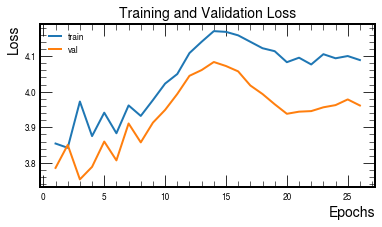

training: 100%|██████████| 151/151 [00:37<00:00,  3.99it/s]


Epoch 1, Loss: 3.854505


test: 100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


Epoch 1, Val Loss: 4.258420
Epoch 1, LR: 0.001


training: 100%|██████████| 151/151 [00:37<00:00,  4.00it/s]


Epoch 2, Loss: 3.842539


test: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Epoch 2, Val Loss: 4.675738
Epoch 2, LR: 0.001


training: 100%|██████████| 151/151 [00:51<00:00,  2.91it/s]


Epoch 3, Loss: 3.972465


test: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


Epoch 3, Val Loss: 3.725105
Epoch 3, LR: 0.001


training: 100%|██████████| 151/151 [00:38<00:00,  3.97it/s]


Epoch 4, Loss: 3.875389


test: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Epoch 4, Val Loss: 4.081722
Epoch 4, LR: 0.001


training: 100%|██████████| 151/151 [00:39<00:00,  3.85it/s]


Epoch 5, Loss: 3.941199


test: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 5, Val Loss: 4.016454
Epoch 5, LR: 0.001


training: 100%|██████████| 151/151 [00:38<00:00,  3.94it/s]


Epoch 6, Loss: 3.883398


test: 100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 6, Val Loss: 3.923092
Epoch 6, LR: 0.001


training: 100%|██████████| 151/151 [00:38<00:00,  3.96it/s]


Epoch 7, Loss: 3.961614


test: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 7, Val Loss: 4.140916
Epoch 7, LR: 0.001


training: 100%|██████████| 151/151 [00:39<00:00,  3.84it/s]


Epoch 8, Loss: 4.125650


test: 100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 8, Val Loss: 4.254940
Epoch 8, LR: 0.001


training: 100%|██████████| 151/151 [00:38<00:00,  3.95it/s]


Epoch 9, Loss: 4.211053


test: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Epoch 9, Val Loss: 4.120773
Epoch 9, LR: 0.001


training: 100%|██████████| 151/151 [00:38<00:00,  3.95it/s]


Epoch 10, Loss: 4.212088


test: 100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Epoch 10, Val Loss: 4.198689
Epoch 10, LR: 0.0005


training: 100%|██████████| 151/151 [00:38<00:00,  3.94it/s]


Epoch 11, Loss: 4.187496


test: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Epoch 11, Val Loss: 4.203935
Epoch 11, LR: 0.0005


training: 100%|██████████| 151/151 [00:38<00:00,  3.95it/s]


Epoch 12, Loss: 4.346436


test: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 12, Val Loss: 3.788664
Epoch 12, LR: 0.0005


training: 100%|██████████| 151/151 [00:38<00:00,  3.93it/s]


Epoch 13, Loss: 4.195106


test: 100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Epoch 13, Val Loss: 4.118325
Epoch 13, LR: 0.0005


training: 100%|██████████| 151/151 [00:38<00:00,  3.92it/s]


Epoch 14, Loss: 4.122308


test: 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Epoch 14, Val Loss: 3.243906
Epoch 14, LR: 0.0005


training: 100%|██████████| 151/151 [00:50<00:00,  3.01it/s]


Epoch 15, Loss: 3.945100


test: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


Epoch 15, Val Loss: 3.958608
Epoch 15, LR: 0.0005


training: 100%|██████████| 151/151 [00:39<00:00,  3.85it/s]


Epoch 16, Loss: 4.047277


test: 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Epoch 16, Val Loss: 4.277980
Epoch 16, LR: 0.0005


training: 100%|██████████| 151/151 [00:37<00:00,  3.98it/s]


Epoch 17, Loss: 4.066420


test: 100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Epoch 17, Val Loss: 3.377513
Epoch 17, LR: 0.0005


training: 100%|██████████| 151/151 [00:38<00:00,  3.95it/s]


Epoch 18, Loss: 4.067781


test: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Epoch 18, Val Loss: 3.681776
Epoch 18, LR: 0.0005


training: 100%|██████████| 151/151 [00:37<00:00,  3.97it/s]


Epoch 19, Loss: 4.120606


test: 100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


Epoch 19, Val Loss: 4.043282
Epoch 19, LR: 0.0005


training: 100%|██████████| 151/151 [00:38<00:00,  3.91it/s]


Epoch 20, Loss: 4.099271


test: 100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Epoch 20, Val Loss: 3.949220
Epoch 20, LR: 0.00025


training: 100%|██████████| 151/151 [00:40<00:00,  3.76it/s]


Epoch 21, Loss: 4.295862


test: 100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


Epoch 21, Val Loss: 3.947944
Epoch 21, LR: 0.00025


training: 100%|██████████| 151/151 [00:38<00:00,  3.90it/s]


Epoch 22, Loss: 3.970690


test: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Epoch 22, Val Loss: 3.210272
Epoch 22, LR: 0.00025


training: 100%|██████████| 151/151 [00:37<00:00,  4.01it/s]


Epoch 23, Loss: 4.175689


test: 100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


Epoch 23, Val Loss: 3.935014
Epoch 23, LR: 0.00025


training: 100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch 24, Loss: 3.955407


test: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


Epoch 24, Val Loss: 3.752497
Epoch 24, LR: 0.00025


training: 100%|██████████| 151/151 [00:38<00:00,  3.95it/s]


Epoch 25, Loss: 4.116996


test: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Epoch 25, Val Loss: 3.992471
Epoch 25, LR: 0.00025


training: 100%|██████████| 151/151 [00:38<00:00,  3.94it/s]


Epoch 26, Loss: 3.977118


test: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


Epoch 26, Val Loss: 3.079824
Epoch 26, LR: 0.00025


training:  75%|███████▍  | 113/151 [00:35<00:12,  2.96it/s]

In [ ]:
# Optionally introduce gradient clipping
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#Initialize Variables for EarlyStopping
best_loss = float('inf')
best_model_weights = None
patience = 10

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

display_loss = display(1, display_id=True)

optimizer.zero_grad()
# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    val_loss = 0
    
    for sample in tqdm(train_dl, desc="training"):
        output = model(sample[0].to(device), sample[1].to(device))
        loss = criterion(output.contiguous().view(-1, vocab_size)-padding, (sample[2]-padding).to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
    train_loss_hist.append(loss)
    model.eval()
    for sample in tqdm(test_dl, desc="test"): 
        output = model(sample[0].to(device), sample[1].to(device))
        loss = criterion(output.contiguous().view(-1, vocab_size)-padding, (sample[2]-padding).to(device))
        optimizer.step()
        val_loss += loss.item()
    val_loss = val_loss / len(test_dl)
    print(f"Epoch {epoch+1}, Val Loss: {loss:.6f}")
    val_loss_hist.append(val_loss)
    
    ax_loss.clear()
    plot_loss(moving_average(train_loss_hist, 8), moving_average(val_loss_hist, 8), ax=ax_loss)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    scheduler.step()
    print(f"Epoch {epoch+1}, LR: {scheduler.get_last_lr()[0]}")
        
        
        
    # Early stopping
#     if loss < best_loss:
#         best_loss = val_loss
#         best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
#         patience = 10  # Reset patience counter
#     else:
#         patience -= 1
#         if patience == 0:
#             break
            
# Load the best model weights
# model.load_state_dict(best_model_weights)

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
epochs = len(train_loss_hist)
ax.plot(range(1, epochs+1), moving_average(train_loss_hist, 8), label='train', linewidth=2)
ax.plot(range(1, epochs+1), moving_average(val_loss_hist, 8), label='val', linewidth=2)
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=14)
ax.set_title("Training and Validation Loss", fontsize=14)
ax.legend()

In [ ]:
val_loss_hist

In [ ]:
# correct = 0
# model.eval() 
# torch.no_grad()
# i = 0
# for sample in tqdm(test_dl, desc="test"):
#     input_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
#     target_tensor = torch.zeros((1, input_length), dtype=torch.long).to(device)
#     edge_tensor = torch.zeros((1, sample.x.shape[0], feature_num), dtype=torch.float).to(device)

#     input_tensor[0, :] = torch.tensor(sample[i].input, dtype=torch.long)
#     target_tensor[0, :] = torch.tensor(sample[i].y_trans, dtype=torch.long)
#     edge_tensor[0, :] = torch.unsqueeze(sample.x, dim=0).float()
            
#     predictions = model(edge_tensor, input_tensor)
#     predicted_index = predictions.argmax(-1)
#     predicted_number = predicted_index[0, -1].item()
# #     res = torch.roll(input_tensor, predicted_number, dims=1)

# #     step = 0
# #     while (predicted_number != 2 and step < 100):  # Disable gradient computation for inference
# #         input_tensor = torch.roll(input_tensor, -1, dims=1)
# #         input_tensor[0, -1] = predicted_number
    
# #         predictions = model(edge_tensor, input_tensor)
# #         predicted_index = predictions.argmax(-1)  # Get the index of the max log-probability for the last position
# #         predicted_number = predicted_index[0, -1].item()  # Convert to Python number
# #         res.append(predicted_number)
# #         step += 1
     
# #     input_tensor = torch.roll(input_tensor, -1, dims=1)
# #     input_tensor[0, -1] = predicted_number 
# #     check = converter.arr2seq(input_tensor[0]) == converter.arr2seq(converter.subseq2arr(sample[0].y, input_length, 0, input_length))
    
#     print(f"Input Sequence: {sample[0].input}")
#     print(f"Predicted: {predicted_number}")
#     print(f"Real: {sample[i].y_trans[-1]}")
# #     print(f"Predicted Sequence: {converter.seq2y(np.array(res.cpu()))}")
# #     print(f"Correct: {check}")
    
# #     try:
# #         origG = torch_geometric.utils.to_networkx(sample, to_undirected=True)
# #         res_nodes, res_edges = sequenceToGraph(converter.arr2seq(input_tensor[0], ignoreTokens=True))
# #         newData = Data(x=sample.x, num_nodes=sample.num_nodes, edge_index=torch.from_numpy(res_edges))
# #         G = torch_geometric.utils.to_networkx(newData, to_undirected=True)

# #         fig, ax = plt.subplots(1, 2)
# #         nx.draw_circular(origG, with_labels=True, ax=ax[0])
# #         nx.draw_circular(G, with_labels=True, ax=ax[1])
# #     except:
# #         print("incorrect sequence")
    
    
# #     correct += check

# # print(f"Percentage of correct guesses: {correct / (len(test_dl))}")

In [ ]:
torch.save({'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': loss
            }, "/eos/user/c/czeh/tranformer_4.pt")


In [ ]:
model_feature_keys = np.array([0,  2,  3,  4,  6,  7, 10, 14, 15, 16, 17, 18, 22, 24, 25, 26, 28, 29])
dataset_training.__getitem__(0)[0][:, model_feature_keys][:, -1]

In [ ]:
dataset_test.get(0).cluster

In [ ]:
dataset_training.node_feature_keys[16]

In [ ]:
G = torch_geometric.utils.to_networkx(dataset_test.get(0), to_undirected=True)

In [ ]:
dataset_training.get(0).x[:, 16]

In [ ]:
fig, ax = plt.subplots(1, 1)
nx.draw(G, with_labels=True, ax=ax)

In [ ]:
dataset_training.get(1).roots